Start with in-game stats dataset of 10754 players (not including goalkeepers) from 2022-2023 season.
After merging with player description dataset and preprocessing, drops to 7400 rows (unique players).
Then, keep only players that have played at least 8 games (1/4 of season).
Split dataset into 4, 1 for each position group.
Import 4 datasets regarding attackers, midfielders, defenders, and goalies.

In [1]:
import pandas as pd
import numpy as np

mid = pd.read_csv("2022_midfielders.csv").drop(['Unnamed: 0', 'Unnamed: 0.1'], axis=1)
best_midfielders = ['Kevin De Bruyne', 'Rodri', 'Luka Modrić','Neymar','Jamal Musiala','James Maddison',
                    'Julian Brandt','Antonio Palumbo','Dominik Szoboszlai','Piotr Zieliński','Christian Eriksen',
                    'Sergej Milinković-Savić','Bruno Fernandes','Leroy Sané','Bernardo Silva', 'Marco Verratti',
                   'Joshua Kimmich','Jude Bellingham', 'Marco Reus', 'Dani Olmo','Pedro Gonçalves','Rodrigo De Paul',
                    'Martin Ødegaard','Dejan Kulusevski','Granit Xhaka','Sandro Tonali','Luis Alberto','Daichi Kamada',
                    'Paulo Dybala','Nicolò Barella','Carles Gil','Enzo Fernández','Bruno Guimarães','Hakan Çalhanoğlu',
                    'Frenkie De Jong', 'Pascal Groß', 'Alexis Mac Allister', 'Moisés Caicedo', 'Adrien Rabiot', 'Jacob Ramsey']

for index, row in mid.iterrows():
    if row['Player'] in best_midfielders:
        mid.loc[index,'Success'] = 1
    else:
        mid.loc[index,'Success'] = 0

In [2]:
from sklearn.model_selection import train_test_split

X = mid.drop('Success', axis=1)
y = mid['Success']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train_new = X_train.drop(['Squad', 'DoB', 'Player', 'Position', 'UID','Born', 'Club', "Preferred Foot", 'Nat', 'Based'], axis=1)
X_train_new.columns = X_train_new.columns.str.strip()

X_test_new = X_test.drop(['Squad', 'DoB', 'Player', 'Position', 'UID','Born', 'Club', "Preferred Foot", 'Nat', 'Based'], axis=1)
X_test_new.columns = X_test_new.columns.str.strip()

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler

# Standardize the data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_new), columns=X_train_new.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test_new), columns=X_test_new.columns)

# Define class weights
class_weights = {0: 1, 1: 6}

# Define the models
models = {
    'Logistic Regression - Newton': LogisticRegression(solver='newton-cg',penalty=None,max_iter=1000,class_weight=class_weights), 
    'Logistic Regression - lbgfs': LogisticRegression(solver='lbfgs',penalty=None,max_iter=2000,class_weight=class_weights), 
    'Logistic Regression - sag': LogisticRegression(solver='sag',penalty=None,max_iter=2000,class_weight=class_weights), 
    'Logistic Regression - saga': LogisticRegression(solver='saga',penalty=None,max_iter=3000,class_weight=class_weights),
    'Logistic Regression' : LogisticRegression(class_weight=class_weights),
    'SVM': SVC(kernel='linear',probability=True,class_weight=class_weights)
}

for model_name, model in models.items():

    model.fit(X_train_scaled, y_train)

    # Fit SVM model
    svm_model = SVC(kernel='linear',probability=True)  # Set probability=True to enable probability estimates
    svm_model.fit(X_train_scaled, y_train)

    # Calculate AIC/BIC
    log_likelihood = np.sum(y_test * np.log(model.predict_proba(X_test_scaled)[:, 1]) + (1 - y_test) * np.log(1 - model.predict_proba(X_test_scaled)[:, 1]))
    num_params = len(model.coef_[0]) + 1
    aic = -2 * log_likelihood + 2 * num_params
    bic = -2 * log_likelihood + num_params * np.log(len(y_test))

    # Print AIC/BIC values
    print("\nAIC for " + model_name + ": " + str(aic))
    print("BIC for " + model_name + ": " + str(bic))


AIC for Logistic Regression - Newton: 138.242416981693
BIC for Logistic Regression - Newton: 250.24265528862537

AIC for Logistic Regression - lbgfs: 138.24659560194198
BIC for Logistic Regression - lbgfs: 250.24683390887435


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(



AIC for Logistic Regression - sag: 156.58246750761356
BIC for Logistic Regression - sag: 268.58270581454593

AIC for Logistic Regression - saga: 137.8358720932022
BIC for Logistic Regression - saga: 249.83611040013457

AIC for Logistic Regression: 129.36140402990674
BIC for Logistic Regression: 241.3616423368391

AIC for SVM: 95.80660960588439
BIC for SVM: 207.80684791281675


In [4]:
import shap

# Fit logistic regression model using scikit-learn
masker = shap.maskers.Independent(data = X_train_scaled)
model = SVC(kernel='linear',probability=True,class_weight=class_weights)
model.fit(X_train_scaled, y_train)
explainer = shap.LinearExplainer(model, masker=masker)
shap_values = explainer(X_test_scaled)

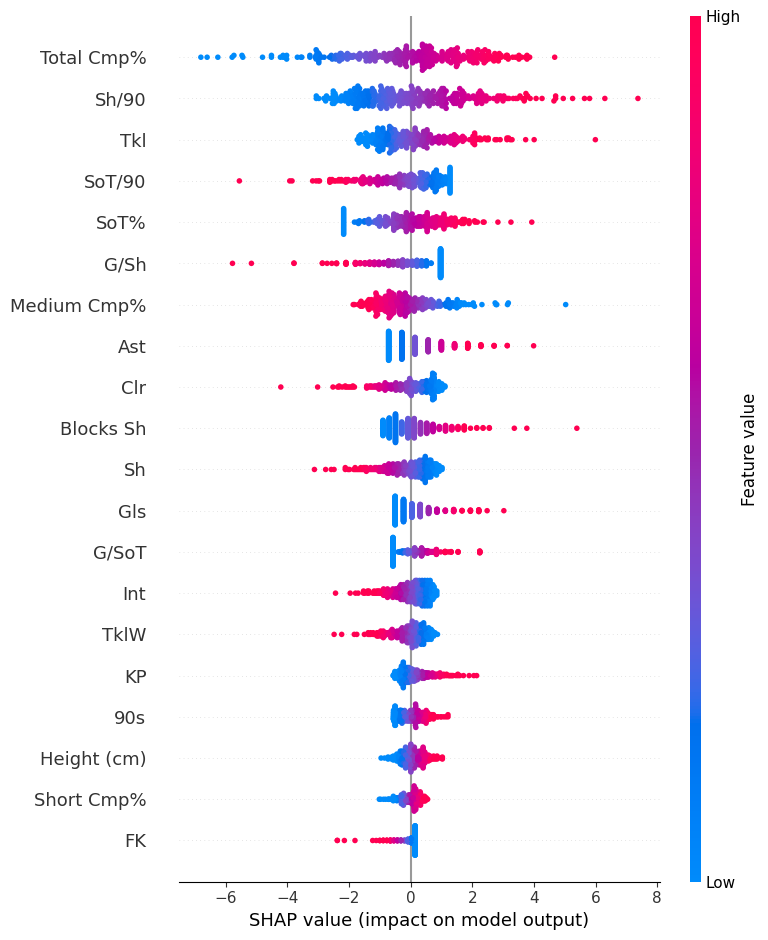

In [8]:
import matplotlib.pyplot as plt

shap.summary_plot(shap_values, max_display=20, show=False)
plt.savefig("shap_summary2.png",dpi=700)

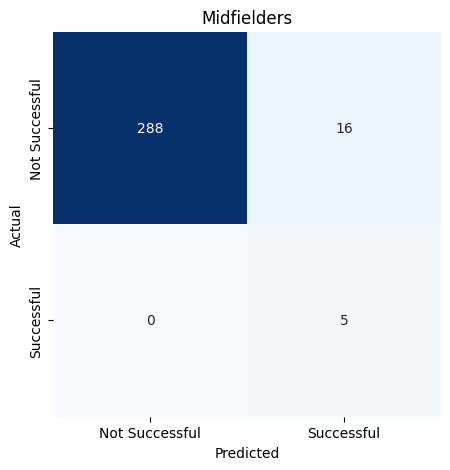

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

y_pred = model.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=['Not Successful', 'Successful'],
            yticklabels=['Not Successful', 'Successful'])
plt.title(f'Midfielders')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [7]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", round(accuracy,3))

# Calculate precision
precision = precision_score(y_test, y_pred)
print("Precision:", round(precision,3))

# Calculate recall (sensitivity)
recall = recall_score(y_test, y_pred)
print("Recall:", round(recall,3))

# Calculate F1-score
f1 = f1_score(y_test, y_pred)
print("F1-Score:", round(f1,3))

Accuracy: 0.948
Precision: 0.238
Recall: 1.0
F1-Score: 0.385
